In [ ]:
# Lets download and unzip dataset

!gdown https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
!unzip -qq Project_data.zip

Downloading...
From: https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
To: /content/Project_data.zip
100% 1.71G/1.71G [00:34<00:00, 49.4MB/s]


In [ ]:
!nvidia-smi

Thu Mar 30 09:10:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
import cv2
# from scipy.misc import imread, imresize
from matplotlib.image import imread
import matplotlib.pyplot as plt
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,2)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        remaining_batches = (len(folder_list)) - (num_batches * batch_size) # Calculate remaining batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.resize(image, (120, 120))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (remaining_batches > 0 ):
            batch_data = np.zeros((remaining_batches,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batches,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_batches): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches * batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.resize(image, (120, 120))

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train/'
val_path = './Project_data/val/'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# num_epochs = 30 # choose the number of epochs
# print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100


In [ ]:
# Plot model performnace
def plot_perfomance(history_model,epoch):

    acc = history_model.history['categorical_accuracy']
    val_acc = history_model.history['val_categorical_accuracy']

    loss = history_model.history['loss']
    val_loss = history_model.history['val_loss']

    epochs_range = range(epoch)

    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model-1 - CNN-RNN (pretrained - MobileNet)



In [ ]:
#write your model here
mobile_net = tf.keras.applications.mobilenet.MobileNet(include_top = False, weights='imagenet',input_shape=(120, 120, 3))

model = Sequential()

model.add(TimeDistributed(mobile_net, input_shape = (15,120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, activation='tanh',return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))


17225924/17225924 [==============================] - 0s 0us/step


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 9216)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                2375936   
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
num_epochs = 30
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:02d}-{loss:.2f}-{categorical_accuracy:.2f}-{val_loss:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history_model1=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-23-a90fa24f9076>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model1=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  ./Project_data/train/ ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.0448 - categorical_accuracy: 0.2881Source path =  ./Project_data/val/ ; batch size = 32

Epoch 1: saving model to model1_2023-03-2705_09_16.394653/model-01-2.04-0.29-1.56-0.23.h5
21/21 [==============================] - 58s 2s/step - loss: 2.0448 - categorical_accuracy: 0.2881 - val_loss: 1.5616 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.3571 - categorical_accuracy: 0.4691
Epoch 2: saving model to model1_2023-03-2705_09_16.394653/model-02-1.36-0.47-1.50-0.26.h5
21/21 [==============================] - 31s 2s/step - loss: 1.3571 - categorical_accuracy: 0.4691 - val_loss: 1.4968 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.0426 - categorical_accuracy: 0.5716
Epoch 3: saving model to model1_2023-03-2705_09_16.394653/mode

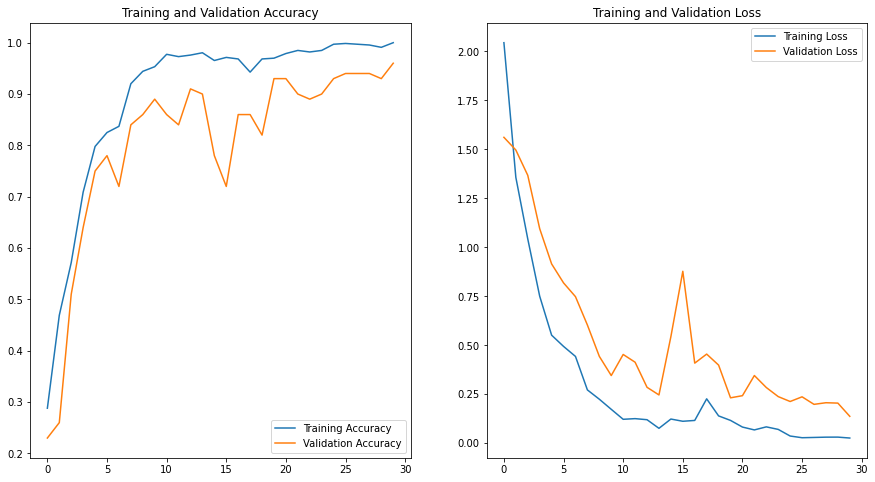

In [ ]:
plot_perfomance(history_model1,num_epochs)

## Model-2 - CNN-RNN (Pretrained-VGG16)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 15, 64)           15009664  
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 15, 32)            9408      
                                                                 
 gru_3 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 5)                 45        
                                                      

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
num_epochs = 60
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history_model2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-30-66a7c22c775c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  ./Project_data/train/ ; batch size = 32
Epoch 1/60
21/21 [==============================] - ETA: 0s - loss: 1.6551 - categorical_accuracy: 0.2006Source path =  ./Project_data/val/ ; batch size = 32

Epoch 1: saving model to model2_2023-03-2705_09_16.394653/model-00001-1.65510-0.20060-1.60214-0.19000.h5
21/21 [==============================] - 35s 2s/step - loss: 1.6551 - categorical_accuracy: 0.2006 - val_loss: 1.6021 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/60
21/21 [==============================] - ETA: 0s - loss: 1.6136 - categorical_accuracy: 0.2202
Epoch 2: saving model to model2_2023-03-2705_09_16.394653/model-00002-1.61358-0.22021-1.59925-0.20000.h5
21/21 [==============================] - 35s 2s/step - loss: 1.6136 - categorical_accuracy: 0.2202 - val_loss: 1.5993 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/60
21/21 [==============================] - ETA: 0s - loss: 1.5967 - categorical_accuracy: 0.2308
Epoch 3: saving model to model2_

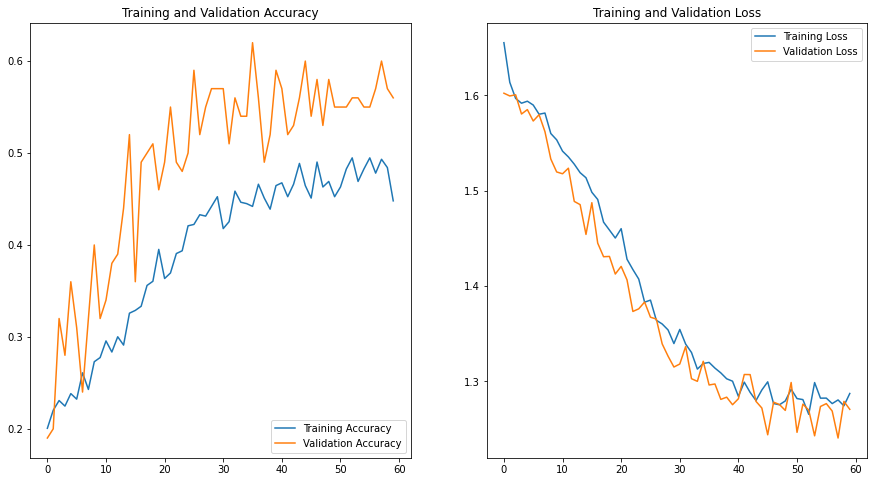

In [ ]:
plot_perfomance(history_model2,num_epochs)

## Model-3 - CNN-RNN (pretrained - Xception)



In [ ]:
#write your model here
xception_model = tf.keras.applications.Xception(include_top = False, weights='imagenet',input_shape=(120, 120, 3))

model = Sequential()

model.add(TimeDistributed(xception_model, input_shape = (15,120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, activation='tanh',return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 15, 4, 4, 2048)   20861480  
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 32768)        0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 64)                8405248   
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, 16)
val_generator = generator(val_path, val_doc, 16)

In [ ]:
model_name = 'model3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
num_epochs = 30
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:02d}-{loss:.2f}-{categorical_accuracy:.2f}-{val_loss:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history_model3=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-20-41ceb303e71f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model3=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  ./Project_data/train/ ; batch size = 16
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.7756 - categorical_accuracy: 0.3542Source path =  ./Project_data/val/ ; batch size = 16

Epoch 1: saving model to model3_2023-03-2706_23_51.768514/model-01-1.78-0.35-1.46-0.44.h5
21/21 [==============================] - 60s 2s/step - loss: 1.7756 - categorical_accuracy: 0.3542 - val_loss: 1.4647 - val_categorical_accuracy: 0.4375 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.3279 - categorical_accuracy: 0.4709
Epoch 2: saving model to model3_2023-03-2706_23_51.768514/model-02-1.33-0.47-1.43-0.44.h5
21/21 [==============================] - 41s 2s/step - loss: 1.3279 - categorical_accuracy: 0.4709 - val_loss: 1.4272 - val_categorical_accuracy: 0.4423 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.1661 - categorical_accuracy: 0.5595
Epoch 3: saving model to model3_2023-03-2706_23_51.768514/mode

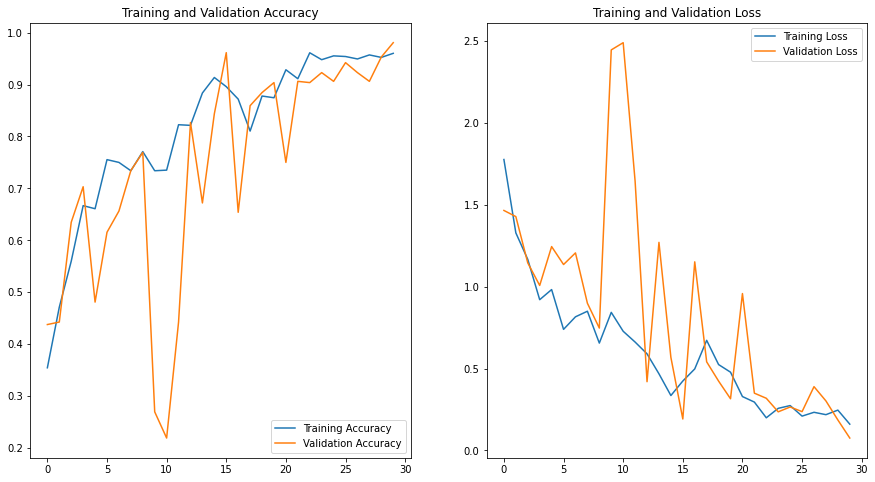

In [ ]:
plot_perfomance(history_model3,num_epochs)

## Model-4 - CNN-RNN (GRU) (pretrained - InceptionResNetV2)



In [ ]:
#write your model here
InceptionResNetV2_model = tf.keras.applications.InceptionResNetV2(include_top = False, weights='imagenet',input_shape=(120, 120, 3))

model = Sequential()

model.add(TimeDistributed(InceptionResNetV2_model, input_shape = (15,120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(64, activation='tanh',return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = tf.keras.optimizers.SGD(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 15, 2, 2, 1536)   54336736  
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 6144)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 64)                1192320   
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_407 (Ba  (None, 64)               256       
 tchNormalization)                                               
                                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, 16)
val_generator = generator(val_path, val_doc, 16)

In [ ]:
model_name = 'model4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
num_epochs = 30
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:02d}-{loss:.2f}-{categorical_accuracy:.2f}-{val_loss:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history_model4=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-15-e26161a7ee47>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model4=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  ./Project_data/train/ ; batch size = 16
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.2899 - categorical_accuracy: 0.2411Source path =  ./Project_data/val/ ; batch size = 16

Epoch 1: saving model to model3_2023-03-2709_20_29.918447/model-01-2.29-0.24-1.75-0.23.h5
21/21 [==============================] - 102s 2s/step - loss: 2.2899 - categorical_accuracy: 0.2411 - val_loss: 1.7484 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.8810 - categorical_accuracy: 0.3364
Epoch 2: saving model to model3_2023-03-2709_20_29.918447/model-02-1.88-0.34-1.62-0.31.h5
21/21 [==============================] - 37s 2s/step - loss: 1.8810 - categorical_accuracy: 0.3364 - val_loss: 1.6176 - val_categorical_accuracy: 0.3077 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.8325 - categorical_accuracy: 0.3601
Epoch 3: saving model to model3_2023-03-2709_20_29.918447/mod

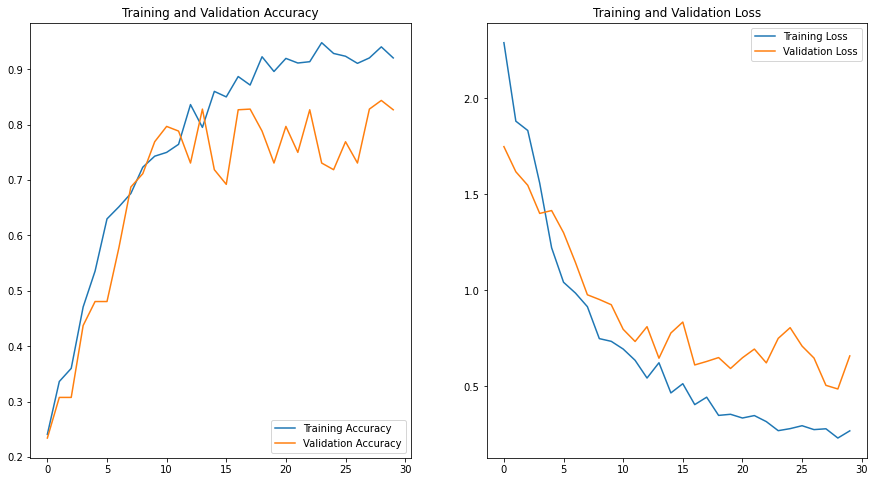

In [ ]:
plot_perfomance(history_model4,num_epochs)

## Model-5 - CNN-RNN (LSTM) (pretrained - InceptionResNetV2)



In [ ]:
#write your model here
InceptionResNetV2_model = tf.keras.applications.InceptionResNetV2(include_top = False, weights='imagenet',input_shape=(120, 120, 3))

model = Sequential()

model.add(TimeDistributed(InceptionResNetV2_model, input_shape = (15,120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, activation='tanh',return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

219055592/219055592 [==============================] - 11s 0us/step


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 2, 2, 1536)   54336736  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 6144)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                1589504   
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 batch_normalization_203 (Ba  (None, 64)               256       
 tchNormalization)                                               
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, 16)
val_generator = generator(val_path, val_doc, 16)

In [ ]:
model_name = 'model5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
num_epochs = 30
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:02d}-{loss:.2f}-{categorical_accuracy:.2f}-{val_loss:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history_model5=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/train/ ; batch size = 16


<ipython-input-14-b4032fa9e162>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model5=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.8058 - categorical_accuracy: 0.3274Source path =  ./Project_data/val/ ; batch size = 16

Epoch 1: saving model to model5_2023-03-3009_10_10.109199/model-01-1.81-0.33-1.64-0.17.h5
21/21 [==============================] - 153s 2s/step - loss: 1.8058 - categorical_accuracy: 0.3274 - val_loss: 1.6395 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.1247 - categorical_accuracy: 0.5688
Epoch 2: saving model to model5_2023-03-3009_10_10.109199/model-02-1.12-0.57-1.61-0.23.h5
21/21 [==============================] - 35s 2s/step - loss: 1.1247 - categorical_accuracy: 0.5688 - val_loss: 1.6082 - val_categorical_accuracy: 0.2308 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.6605 - categorical_accuracy: 0.7500
Epoch 3: saving model to model5_2023-03-3009_10_10.109199/model-03-0.66-0.75-1.36-0.54.h5
21/21 [===================

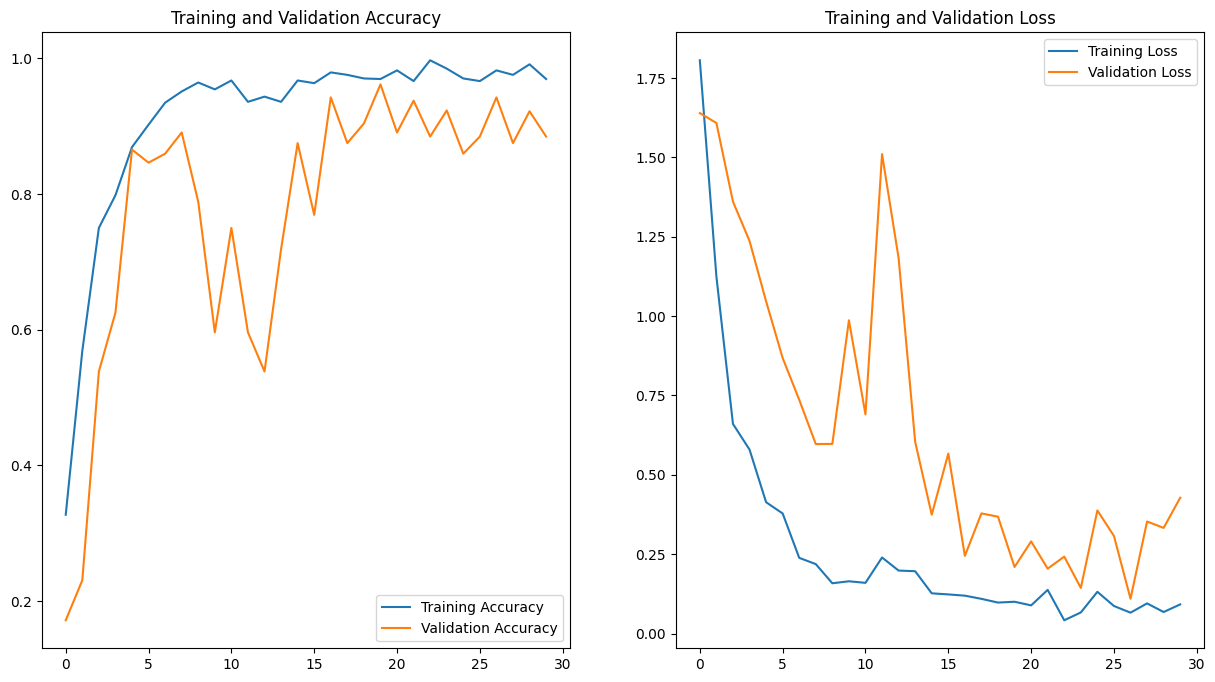

In [ ]:
plot_perfomance(history_model5,num_epochs)

In [ ]:
!cp -r /content/model5_2023-03-3009_10_10.109199/model-20-0.10-0.97-0.21-0.96.h5 /content/drive/MyDrive

## Model-6 - 3D-CNN



In [ ]:
#write your model here
model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(15,120,120,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 15, 120, 120, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 120, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 120, 128)   221312    
                                                                 
 batch_normalization_1 (Batc  (None, 7, 60, 120, 128)  5

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, 16)
val_generator = generator(val_path, val_doc, 16)

In [ ]:
model_name = 'model6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
num_epochs = 30
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:02d}-{loss:.2f}-{categorical_accuracy:.2f}-{val_loss:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history_model6=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-14-08c8a0a7f6dd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model6=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  ./Project_data/train/ ; batch size = 16
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 38.8906 - categorical_accuracy: 0.2946Source path =  ./Project_data/val/ ; batch size = 16

Epoch 1: saving model to model6_2023-03-3005_28_25.211400/model-01-38.89-0.29-51.66-0.25.h5
21/21 [==============================] - 39s 1s/step - loss: 38.8906 - categorical_accuracy: 0.2946 - val_loss: 51.6579 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 3.5334 - categorical_accuracy: 0.3945
Epoch 2: saving model to model6_2023-03-3005_28_25.211400/model-02-3.53-0.39-10.85-0.27.h5
21/21 [==============================] - 27s 1s/step - loss: 3.5334 - categorical_accuracy: 0.3945 - val_loss: 10.8460 - val_categorical_accuracy: 0.2692 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.3081 - categorical_accuracy: 0.5685
Epoch 3: saving model to model6_2023-03-3005_28_25.2114

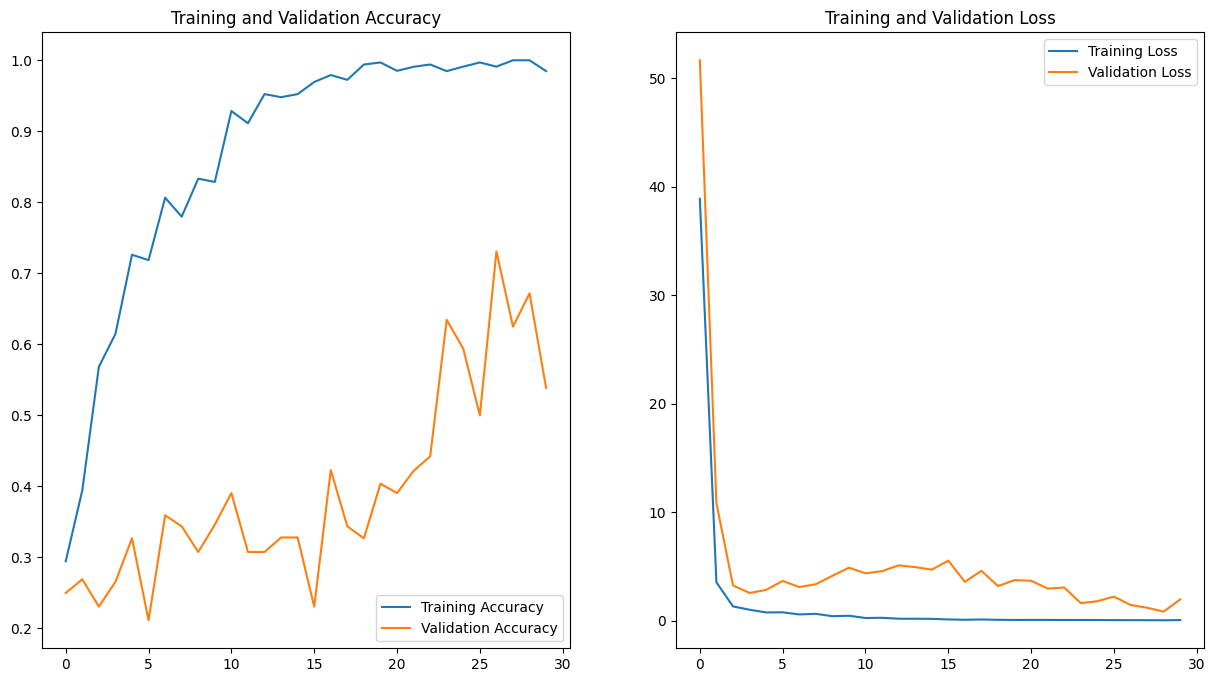

In [ ]:
plot_perfomance(history_model6,num_epochs)

## Model-7 - 3D-CNN
Model-6 is overfitted lets handel overfitting by adding more droupts layes in model architectures and redue model complexity


In [ ]:
#write your model here
model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(15,120,120,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 120, 120, 64)  5248      
                                                                 
 batch_normalization_9 (Batc  (None, 15, 120, 120, 64)  256      
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 15, 120, 120, 64)  0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 60, 120, 64)   0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 60, 120, 128)   221312    
                                                                 
 batch_normalization_10 (Bat  (None, 7, 60, 120, 128) 

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, 16)
val_generator = generator(val_path, val_doc, 16)

In [ ]:
model_name = 'model7_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
num_epochs = 60
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:02d}-{loss:.2f}-{categorical_accuracy:.2f}-{val_loss:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history_model7=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-38-c40b8332ad53>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model7=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  ./Project_data/train/ ; batch size = 16
Epoch 1/60
21/21 [==============================] - ETA: 0s - loss: 31.0717 - categorical_accuracy: 0.2411Source path =  ./Project_data/val/ ; batch size = 16

Epoch 1: saving model to model7_2_2023-03-3005_28_25.211400/model-01-31.07-0.24-5.19-0.14.h5
21/21 [==============================] - 47s 1s/step - loss: 31.0717 - categorical_accuracy: 0.2411 - val_loss: 5.1938 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 2/60
21/21 [==============================] - ETA: 0s - loss: 1.5286 - categorical_accuracy: 0.3211
Epoch 2: saving model to model7_2_2023-03-3005_28_25.211400/model-02-1.53-0.32-3.44-0.21.h5
21/21 [==============================] - 22s 1s/step - loss: 1.5286 - categorical_accuracy: 0.3211 - val_loss: 3.4358 - val_categorical_accuracy: 0.2115 - lr: 0.0010
Epoch 3/60
21/21 [==============================] - ETA: 0s - loss: 1.3575 - categorical_accuracy: 0.4137
Epoch 3: saving model to model7_2_2023-03-3005_28_25.21

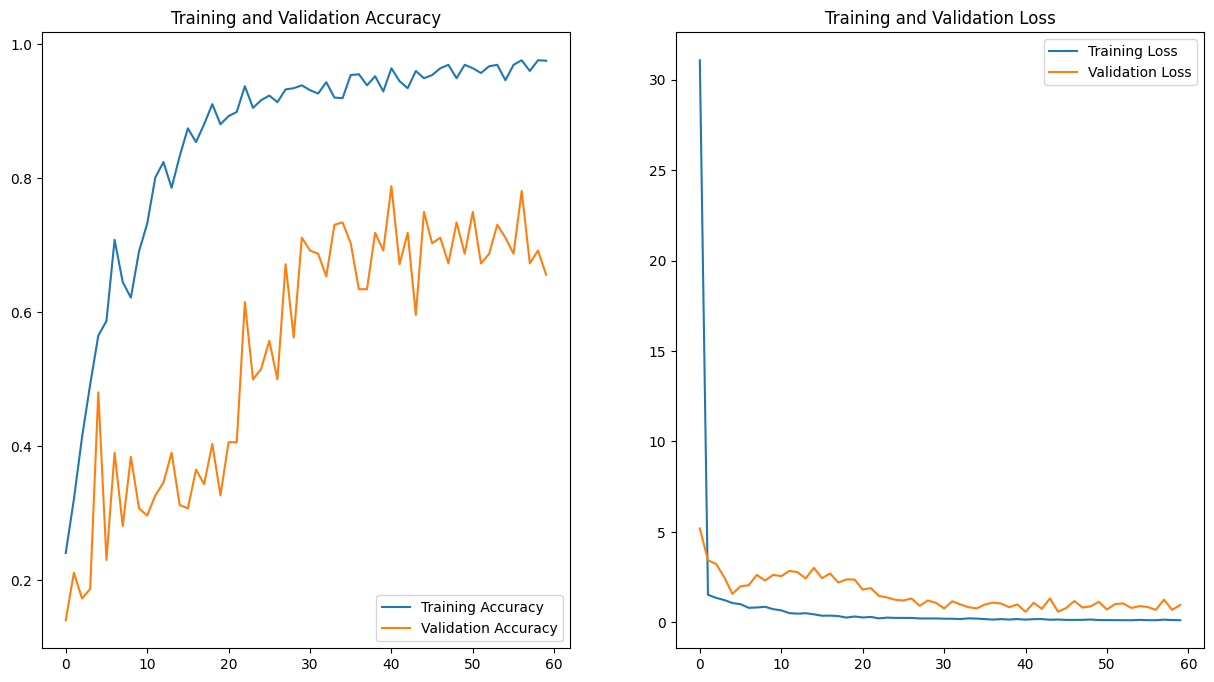

In [ ]:
plot_perfomance(history_model7,num_epochs)

## Model-8 - 3D-CNN
Lets try new model architectures


In [ ]:
#write your model here
model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same',input_shape=(15,120,120,3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256,activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_19 (Conv3D)          (None, 15, 120, 120, 16)  1312      
                                                                 
 activation_19 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_21 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_20 (Conv3D)          (None, 7, 60, 60, 32)     13856     
                                                                 
 activation_20 (Activation)  (None, 7, 60, 60, 32)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, 16)
val_generator = generator(val_path, val_doc, 16)

In [ ]:
model_name = 'model8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
num_epochs = 45
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:02d}-{loss:.2f}-{categorical_accuracy:.2f}-{val_loss:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history_model8=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-59-26c38a6c21b0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model8=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  ./Project_data/train/ ; batch size = 16
Epoch 1/45
21/21 [==============================] - ETA: 0s - loss: 1.9279 - categorical_accuracy: 0.4107Source path =  ./Project_data/val/ ; batch size = 16

Epoch 1: saving model to model8_2023-03-3005_28_25.211400/model-01-1.93-0.41-4.38-0.14.h5
21/21 [==============================] - 25s 1s/step - loss: 1.9279 - categorical_accuracy: 0.4107 - val_loss: 4.3809 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 2/45
21/21 [==============================] - ETA: 0s - loss: 1.7005 - categorical_accuracy: 0.4128
Epoch 2: saving model to model8_2023-03-3005_28_25.211400/model-02-1.70-0.41-3.30-0.33.h5
21/21 [==============================] - 19s 944ms/step - loss: 1.7005 - categorical_accuracy: 0.4128 - val_loss: 3.2954 - val_categorical_accuracy: 0.3269 - lr: 0.0010
Epoch 3/45
21/21 [==============================] - ETA: 0s - loss: 1.4602 - categorical_accuracy: 0.5387
Epoch 3: saving model to model8_2023-03-3005_28_25.211400/m

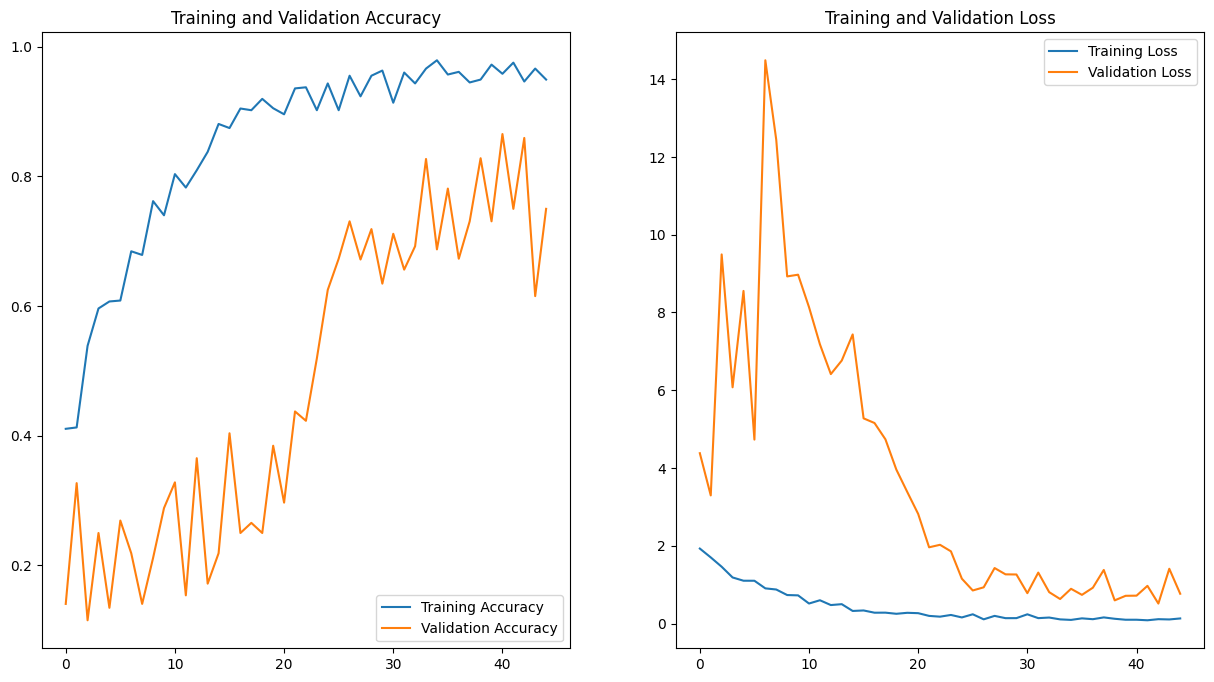

In [ ]:
plot_perfomance(history_model8,num_epochs)

## Lets run few more experiment with image size of 160 * 160

Lets rewrite code for generator for image size of 160*160

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,2)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        remaining_batches = (len(folder_list)) - (num_batches * batch_size) # Calculate remaining batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),160,160,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.resize(image, (160,160))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (remaining_batches > 0 ):
            batch_data = np.zeros((remaining_batches,len(img_idx),160,160,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batches,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_batches): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches * batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.resize(image, (160,160))

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

## Model-9 - 3D-CNN
Same architectures of model 8 with image size of 160*160


In [ ]:
#write your model here
model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same',input_shape=(15,160,160,3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256,activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = tf.keras.optimizers.SGD(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 160, 160, 16)  1312      
                                                                 
 activation_9 (Activation)   (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization_15 (Bat  (None, 15, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 80, 80, 16)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 80, 80, 32)     13856     
                                                                 
 activation_10 (Activation)  (None, 7, 80, 80, 32)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, 32)
val_generator = generator(val_path, val_doc, 32)

In [ ]:
model_name = 'model9' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
num_epochs = 70
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:02d}-{loss:.2f}-{categorical_accuracy:.2f}-{val_loss:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history_model9=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-37-13f91b97740a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model9=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  ./Project_data/train/ ; batch size = 32
Epoch 1/70
21/21 [==============================] - ETA: 0s - loss: 2.3400 - categorical_accuracy: 0.2775Source path =  ./Project_data/val/ ; batch size = 32

Epoch 1: saving model to model9_2023-03-3007_22_56.502529/model-01-2.34-0.28-1.62-0.23.h5
21/21 [==============================] - 43s 2s/step - loss: 2.3400 - categorical_accuracy: 0.2775 - val_loss: 1.6199 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/70
21/21 [==============================] - ETA: 0s - loss: 1.5834 - categorical_accuracy: 0.4736
Epoch 2: saving model to model9_2023-03-3007_22_56.502529/model-02-1.58-0.47-1.90-0.22.h5
21/21 [==============================] - 42s 2s/step - loss: 1.5834 - categorical_accuracy: 0.4736 - val_loss: 1.9000 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/70
21/21 [==============================] - ETA: 0s - loss: 1.2731 - categorical_accuracy: 0.5505
Epoch 3: saving model to model9_2023-03-3007_22_56.502529/mode

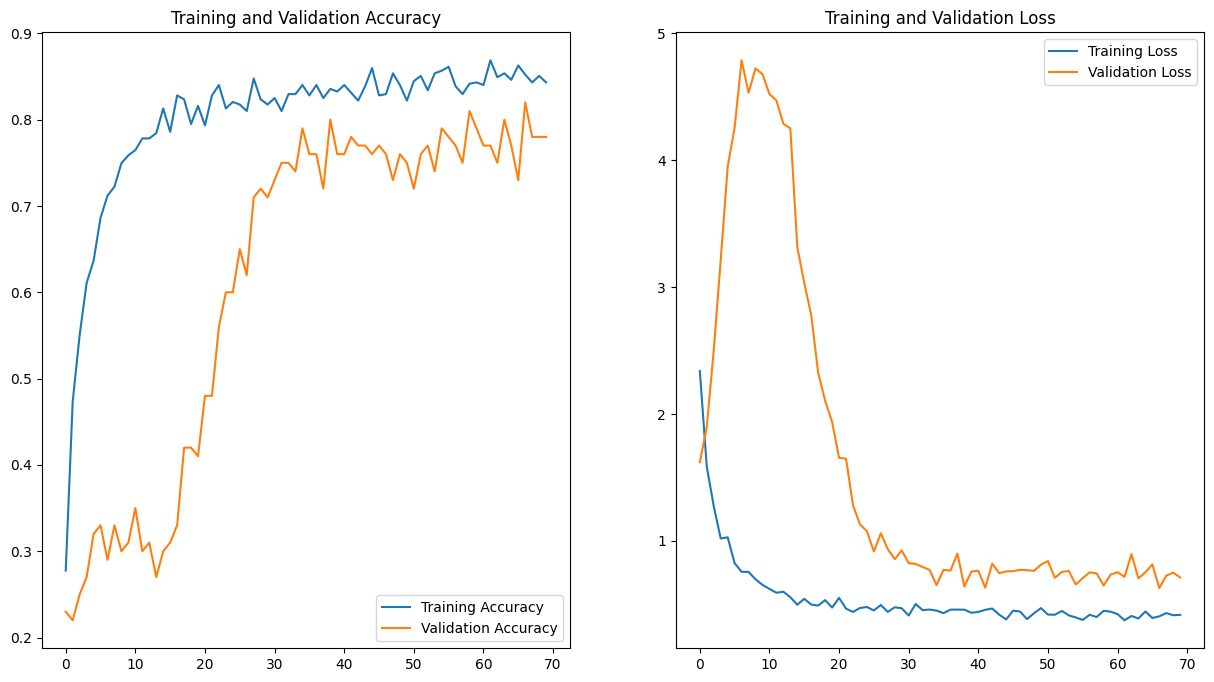

In [ ]:
plot_perfomance(history_model9,num_epochs)

# Experiments Summary and Conclusions  

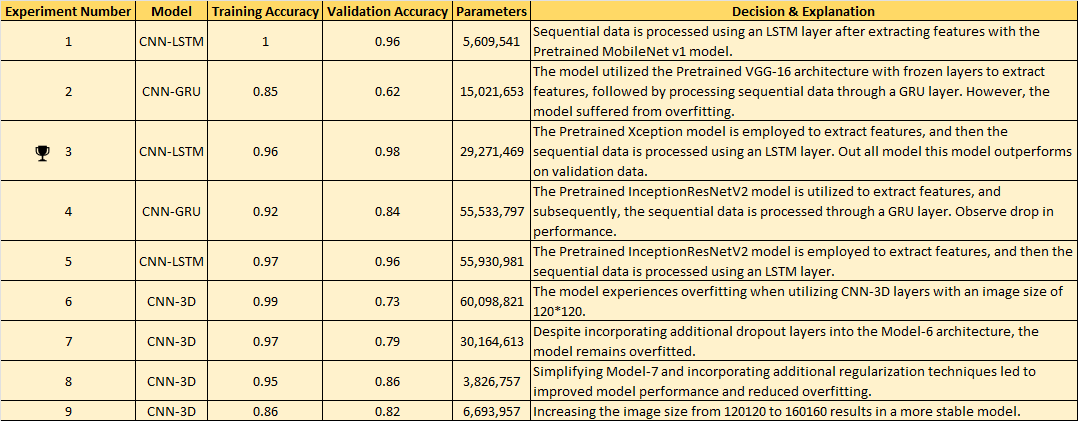